In [ ]:
https://github.com/dim4o/gender-recognizer/blob/master/Gender%20Classification.ipynb
    https://github.com/google-research/google-research/blob/2f8d5e788c6295d71f5400806e5ed1e2a00f8f19/maml_nonexclusive/maml_classification/maml.py

In [1]:
import os
import urllib
import tarfile
import re
from shutil import copyfile
import random
import time
import itertools
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import urllib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, SelectPercentile
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Constants
NUMBER_OF_SAMPLES = 2900
RESIZE_SHAPE = (40, 40)
FEMALE_CLASS = 0
MALE_CLASS = 1

In [2]:
import os
os.chdir(r'D:\2nd_semester\bigdatascience\project\P1\img_align_celeba\img_align_celeba\\')

In [2]:

directory_female = r"D:\2nd_semester\bigdatascience\project\P1\fake_faces\\"
directory_male = r"D:\2nd_semester\bigdatascience\project\P1\test_real_faces\\"


In [3]:
# test print for the selected names
female_image_names = os.listdir(directory_female)
male_image_names = os.listdir(directory_male)
print(len(female_image_names))
print(len(male_image_names))

2000
2000


# Dimensionality reduction
Image transformations
Now I'll extract the features from the image following these actions:

Get the original image
Convet the image to grayscale
Define the region of interests. Use haar faces to detect a face (if exists) on the image. If there is more than one face, I'll get the square with the larger area.
Crop the square from the gray image
Apply gaussian kernel over the cropped image to reduce the noise.
Resize the image to 40x40px

In [4]:
gender_faces_data = None
gender_faces_data = np.empty(shape=(0,RESIZE_SHAPE[0]*RESIZE_SHAPE[1]+1)) #64*64+1
face_cascade = cv2.CascadeClassifier(r'D:\2nd_semester\bigdatascience\project\face_data\face.xml')

def extract_features(image_path, label):
    """ Extracts features from a image
    :param image_path: the path to the image
    :param label: the label of the image
    :return: extracted features from the image with the corresponding label as a row matrix
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    row = None
    '''faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces is not ():
        face = sorted(faces, key=lambda x: (x[2] * x[3]), reverse=True)[0]
        x, y, width, height = face
        face_gray = gray[y: y + height, x: x + width]
        
        # apply Gaussian kernel
        kernel = np.ones((3,3),np.float32)/9
        face_gray = cv2.filter2D(face_gray,-1,kernel)
        
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        row = np.append(resized.ravel(), label)'''

    return np.append((cv2.resize(gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)),label)

def append_data(prefix_path, label, gender_faces_data):
    """ Appends data to a numpy array"""
    image_names = os.listdir(prefix_path)
    for image_path in image_names:
        # print(image_path)
        curr_row = extract_features(prefix_path + image_path, label)
        if curr_row is not None:
            gender_faces_data = np.append(gender_faces_data, [curr_row], axis=0)
        
    return gender_faces_data

In [5]:
# Append the female faces
gender_faces_data = append_data(directory_female, FEMALE_CLASS, gender_faces_data)
female_data = gender_faces_data

# Append the male faces
gender_faces_data = append_data(directory_male, MALE_CLASS, gender_faces_data)

print("Females count: {}".format(female_data.shape[0]))
print("Males count: {}".format(gender_faces_data.shape[0] - female_data.shape[0]))
print("Gender data shape: {}".format(gender_faces_data.shape))

Females count: 2000
Males count: 2000
Gender data shape: (4000, 1601)


In [6]:
# Suffle the data
np.random.shuffle(gender_faces_data)
gender_faces_data

array([[ 71.,  71.,  81., ...,  56.,  67.,   0.],
       [154., 107., 122., ...,  87.,  51.,   0.],
       [ 42.,  41.,  39., ...,  37.,  26.,   0.],
       ...,
       [238., 238., 238., ...,  39.,  39.,   1.],
       [ 88., 126., 142., ...,  25.,  27.,   0.],
       [ 59.,  54.,  62., ...,   2.,   2.,   1.]])

In [7]:
np.savetxt(r'D:\2nd_semester\bigdatascience\meta\fake_real__data_40x40_large_2.csv', gender_faces_data.astype(np.int), delimiter=",")

In [8]:
# Time 1-2 min, size ~200Mb
# downloads the dataset if does not exists
dataset_file = r'D:\2nd_semester\bigdatascience\meta\fake_real__data_40x40_large_2.csv'


gender_faces_data = pd.read_csv(dataset_file, sep=',', header=None)
gender_faces_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,71.0,71.0,81.0,89.0,91.0,94.0,107.0,114.0,117.0,123.0,...,94.0,103.0,118.0,116.0,88.0,61.0,48.0,56.0,67.0,0.0
1,154.0,107.0,122.0,120.0,129.0,134.0,140.0,143.0,144.0,145.0,...,74.0,84.0,88.0,85.0,83.0,81.0,89.0,87.0,51.0,0.0
2,42.0,41.0,39.0,44.0,64.0,78.0,44.0,44.0,44.0,37.0,...,1.0,53.0,75.0,86.0,72.0,77.0,53.0,37.0,26.0,0.0
3,147.0,197.0,196.0,185.0,170.0,131.0,125.0,130.0,142.0,147.0,...,31.0,43.0,39.0,57.0,43.0,33.0,31.0,32.0,36.0,0.0
4,87.0,73.0,96.0,93.0,112.0,131.0,143.0,145.0,141.0,141.0,...,56.0,51.0,39.0,16.0,78.0,82.0,74.0,100.0,119.0,0.0


In [9]:
# get features
features = gender_faces_data.to_numpy()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

# get labels
labels = gender_faces_data.to_numpy()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

(4000, 1600)
(4000,)
[0. 0. 0. ... 1. 0. 1.]


In [10]:
# calculates the final counts
unique, count = np.unique(labels, return_counts=True)
print("Females count: {}".format(count[0]))
print("Males count: {}".format(count[1]))
# out = np.histogram(labels, bins=labels)
print(dict(zip(unique, count)))

Females count: 2000
Males count: 2000
{0.0: 2000, 1.0: 2000}


# Choice of the best features
It is difficult to find the best PCA parameters but I can make very rough approximations with something like grid search.

In [11]:
print("Features shape: {}".format(features.shape))
features_counts = [80, 140, 200, 260, 320, 380, 440, 1000]
test_scores = []
train_scores = []
for f_count in features_counts:
    print("Reducing features to {} ...".format(f_count))
    pca = PCA(n_components=f_count)

    pca.fit(features)
    reduced_features = pca.transform(features)
    
    features_train, features_test, labels_train, labels_test = train_test_split(
        reduced_features, labels, train_size=0.7, test_size=0.3, random_state=0)
    
    logistic_regression = LogisticRegression(C=0.001)
    logistic_regression.fit(features_train, labels_train)
    
    test_score = logistic_regression.score(features_test, labels_test)
    train_score = logistic_regression.score(features_train, labels_train)
    
    print("    train_score: {}".format(train_score))
    print("    test_score: {}".format(test_score))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
print("Finished.")

Features shape: (4000, 1600)
Reducing features to 80 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.9883333333333333
Reducing features to 140 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.99
Reducing features to 200 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.9916666666666667
Reducing features to 260 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.9933333333333333
Reducing features to 320 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.9925
Reducing features to 380 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.9925
Reducing features to 440 ...


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    train_score: 1.0
    test_score: 0.9925
Reducing features to 1000 ...
    train_score: 1.0
    test_score: 0.995
Finished.


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


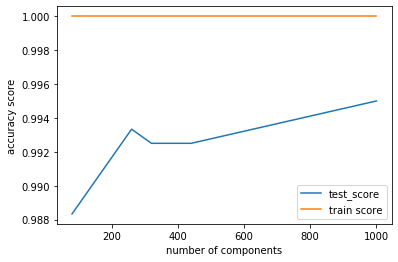

In [13]:

plt.plot(features_counts, test_scores)
plt.plot(features_counts, train_scores)
plt.legend(["test_score", "train score"])
plt.xlabel("number of components")
plt.ylabel("accuracy score")
plt.show()

# Model selection
As we have seen, the data is well balanced and therefore I will choose Accuracy Score for metric. Also I will use Learning Curve, ROC curve and Confusion Matrix to analyze the results.

In [14]:
gender_faces_data = pd.read_csv(r'D:\2nd_semester\bigdatascience\meta\fake_real__data_40x40_large_2.csv', sep=',', header=None)

print(gender_faces_data.shape)
gender_faces_data.head()

(4000, 1601)


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,71.0,71.0,81.0,89.0,91.0,94.0,107.0,114.0,117.0,123.0,...,94.0,103.0,118.0,116.0,88.0,61.0,48.0,56.0,67.0,0.0
1,154.0,107.0,122.0,120.0,129.0,134.0,140.0,143.0,144.0,145.0,...,74.0,84.0,88.0,85.0,83.0,81.0,89.0,87.0,51.0,0.0
2,42.0,41.0,39.0,44.0,64.0,78.0,44.0,44.0,44.0,37.0,...,1.0,53.0,75.0,86.0,72.0,77.0,53.0,37.0,26.0,0.0
3,147.0,197.0,196.0,185.0,170.0,131.0,125.0,130.0,142.0,147.0,...,31.0,43.0,39.0,57.0,43.0,33.0,31.0,32.0,36.0,0.0
4,87.0,73.0,96.0,93.0,112.0,131.0,143.0,145.0,141.0,141.0,...,56.0,51.0,39.0,16.0,78.0,82.0,74.0,100.0,119.0,0.0


In [15]:
features = gender_faces_data.to_numpy()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

(4000, 1600)


In [16]:
labels = gender_faces_data.to_numpy()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel()
print(labels.shape)
print(labels)

(4000,)
[0. 0. 0. ... 1. 0. 1.]


# Define util functions

# Logistic Regression model
Basic Logistic Regression
I will create a pipeline for the models because it is convenient to use not only during the training but also during the use of the model. I can simply call pipeline_model.predict(...) and it will handle the PCA and Scaler transformations for the input data. It is therefore a prerequisite for fewer mistakes. On the other hand, invoking PCA and Scaler every time when creating each model will reduce performance. But for the purpose of this study, this is not so important.

In [21]:

# split the data to train and test set
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=42)

In [44]:
# creates a pipeline for Logistic Regression
logistic_regression_pipe = None
logistic_regression = LogisticRegression(random_state=42)
logistic_regression_pipe = Pipeline(steps=[('scaler_before', StandardScaler()), 
                          ('pca', PCA(n_components=150)),
                          ('scaler_after', StandardScaler()),
                          ('classifier', logistic_regression)])

In [45]:

# fit the basic Logistic Regression model
logistic_regression_pipe.fit(features_train[:151], labels_train[:151])

Pipeline(memory=None,
         steps=[('scaler_before',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scaler_after',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [46]:
print("Basic logistic regression test accuracy score: {}".format(
    logistic_regression_pipe.score(features_test, labels_test)))
print("Basic logistic regression train accuracy score: {}".format(
    logistic_regression_pipe.score(features_train, labels_train)))
print("Basic logistic regression F1 score: {}".format(
    f1_score(labels_test, logistic_regression_pipe.predict(features_test))))

Basic logistic regression test accuracy score: 0.975
Basic logistic regression train accuracy score: 0.9796428571428571
Basic logistic regression F1 score: 0.9749582637729549
